Epoch 1 | MLP Acc: 0.1179 | AE MSE: 0.2316 | RBM Err: 0.2499
Epoch 2 | MLP Acc: 0.1675 | AE MSE: 0.1553 | RBM Err: 0.1718
Epoch 3 | MLP Acc: 0.2286 | AE MSE: 0.0803 | RBM Err: 0.1397
Epoch 4 | MLP Acc: 0.2979 | AE MSE: 0.0745 | RBM Err: 0.1495
Epoch 5 | MLP Acc: 0.3517 | AE MSE: 0.0723 | RBM Err: 0.1440

Detected 468 outliers at threshold 0.1067


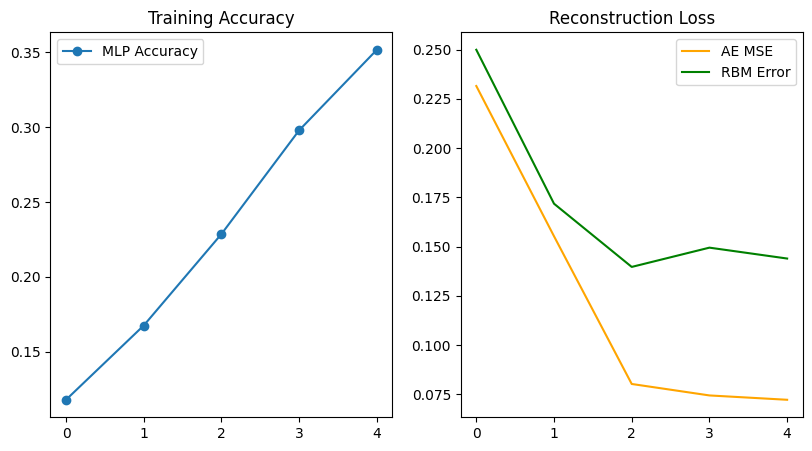

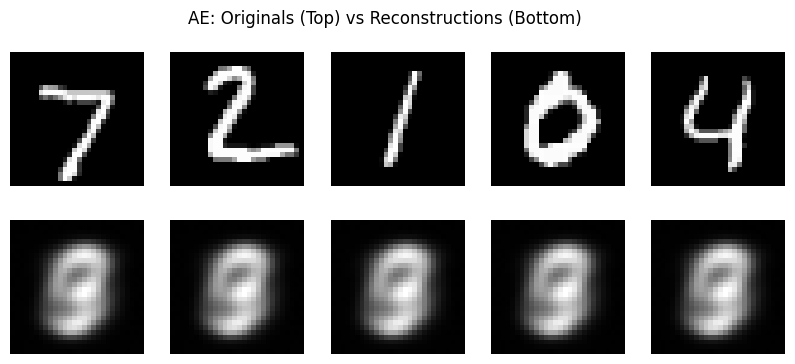

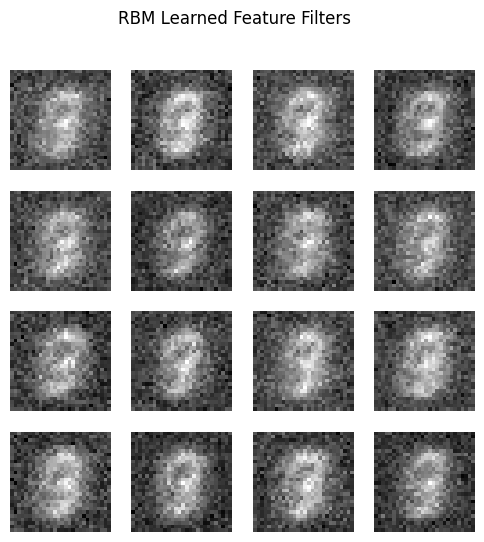

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# --- 1. DATA PREPROCESSING ---
def get_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Normalize and flatten
    x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
    # One-hot encoding for MLP
    y_train_oh = np.eye(10)[y_train]
    y_test_oh = np.eye(10)[y_test]
    return x_train, y_train, y_train_oh, x_test, y_test, y_test_oh

# --- 2. MULTI-LAYER PERCEPTRON (MLP) ---
class MLP:
    def __init__(self, input_size, hidden_size, output_size, lr=0.1):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.lr = lr

    def relu(self, x): return np.maximum(0, x)

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def forward(self, x):
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        return self.softmax(self.z2)

    def train_step(self, x, y):
        m = x.shape[0]
        probs = self.forward(x)
        dz2 = probs - y
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * (self.z1 > 0)
        dW1 = np.dot(x.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

# --- 3. SPARSE AUTOENCODER ---
class Autoencoder:
    def __init__(self, input_size, hidden_size, lr=0.5, l1_penalty=1e-5):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, input_size) * 0.01
        self.b2 = np.zeros((1, input_size))
        self.lr, self.l1 = lr, l1_penalty

    def sigmoid(self, x): return 1 / (1 + np.exp(-x))

    def forward(self, x):
        self.h = self.sigmoid(np.dot(x, self.W1) + self.b1)
        self.out = self.sigmoid(np.dot(self.h, self.W2) + self.b2)
        return self.h, self.out

    def train_step(self, x):
        m = x.shape[0]
        h, out = self.forward(x)
        diff = out - x
        dout = diff * out * (1 - out)
        dW2 = np.dot(h.T, dout) / m
        db2 = np.sum(dout, axis=0, keepdims=True) / m
        dh = np.dot(dout, self.W2.T) * h * (1 - h)
        # Sparsity penalty (L1)
        dW1 = (np.dot(x.T, dh) + self.l1 * np.sign(self.W1)) / m
        db1 = np.sum(dh, axis=0, keepdims=True) / m
        self.W1, self.b1 = self.W1 - self.lr * dW1, self.b1 - self.lr * db1
        self.W2, self.b2 = self.W2 - self.lr * dW2, self.b2 - self.lr * db2
        return np.mean(diff**2)

# --- 4. RESTRICTED BOLTZMANN MACHINE (RBM) ---
class RBM:
    def __init__(self, n_v, n_h, lr=0.1):
        self.W = np.random.randn(n_v, n_h) * 0.01
        self.v_bias = np.zeros(n_v)
        self.h_bias = np.zeros(n_h)
        self.lr = lr

    def sigmoid(self, x): return 1 / (1 + np.exp(-x))

    def train_step(self, v0):
        # Positive Phase
        h0_prob = self.sigmoid(np.dot(v0, self.W) + self.h_bias)
        h0_states = (h0_prob > np.random.rand(*h0_prob.shape)).astype(float)
        # Negative Phase (CD-1)
        v1_prob = self.sigmoid(np.dot(h0_states, self.W.T) + self.v_bias)
        h1_prob = self.sigmoid(np.dot(v1_prob, self.W) + self.h_bias)
        # Updates
        self.W += self.lr * (np.dot(v0.T, h0_prob) - np.dot(v1_prob.T, h1_prob)) / v0.shape[0]
        self.v_bias += self.lr * np.mean(v0 - v1_prob, axis=0)
        self.h_bias += self.lr * np.mean(h0_prob - h1_prob, axis=0)
        return np.mean((v0 - v1_prob)**2)

# --- 5. EXECUTION & VISUALIZATION ---
x_train, y_train, y_train_oh, x_test, y_test, y_test_oh = get_data()
mlp_accs, ae_errs, rbm_errs = [], [], []

# Training
mlp = MLP(784, 128, 10)
ae = Autoencoder(784, 32)
rbm = RBM(784, 64)

for epoch in range(5):
    # MLP
    mlp.train_step(x_train, y_train_oh)
    acc = np.mean(np.argmax(mlp.forward(x_test), axis=1) == y_test)
    mlp_accs.append(acc)
    # AE
    ae_err = ae.train_step(x_train)
    ae_errs.append(ae_err)
    # RBM
    rbm_err = rbm.train_step((x_train > 0.5).astype(float))
    rbm_errs.append(rbm_err)
    print(f"Epoch {epoch+1} | MLP Acc: {acc:.4f} | AE MSE: {ae_err:.4f} | RBM Err: {rbm_err:.4f}")

# Outlier Detection
_, reconstructions = ae.forward(x_test)
mse = np.mean((x_test - reconstructions)**2, axis=1)
threshold = np.mean(mse) + 2 * np.std(mse)
outliers = np.where(mse > threshold)[0]
print(f"\nDetected {len(outliers)} outliers at threshold {threshold:.4f}")

# Final Plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.plot(mlp_accs, label='MLP Accuracy', marker='o'); plt.legend(); plt.title("Training Accuracy")
plt.subplot(1, 3, 2); plt.plot(ae_errs, label='AE MSE', color='orange'); plt.plot(rbm_errs, label='RBM Error', color='green'); plt.legend(); plt.title("Reconstruction Loss")

# Visualizing AE Reconstructions
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1); plt.imshow(x_test[i].reshape(28,28), cmap='gray'); plt.axis('off')
    plt.subplot(2, 5, i+6); plt.imshow(reconstructions[i].reshape(28,28), cmap='gray'); plt.axis('off')
plt.suptitle("AE: Originals (Top) vs Reconstructions (Bottom)")

# Visualizing RBM Filters
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1); plt.imshow(rbm.W[:, i].reshape(28,28), cmap='gray'); plt.axis('off')
plt.suptitle("RBM Learned Feature Filters")
plt.show()